<a href="https://colab.research.google.com/github/laurlouie/Climate/blob/main/DATA_3320_Climate_project_complete_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The purpose of this project is to leverage an extensive dataset encompassing over 80 years of daily observations pertaining to sea surface temperature, wave height, and wind speed across seven principal oceans including: the Arctic, North Atlantic, South Atlantic, Indian, North Pacific, South Pacific, and Southern Oceans.

Our primary objective entails scrutinizing these time series datasets to discern discernible patterns indicative of long-term trends. Specifically, our focus lies on detecting phenomena such as oceanic warming and potential shifts in storm frequency or intensity. This project is aimed at finding insights of significance to the broader scientific community and further elucidate our understanding of oceanic dynamics over prolonged temporal scales.

# Data

The approach relies on tapping into data from the ERA5 Reanalysis Product, a crucial tool in climate research. Reanalysis data blends historical observations with computer models to give us a consistent global picture of various factors. ERA5, crafted by the top-notch European Centre for Medium-Range Weather Forecasting (ECMWF), is our go-to choice for tracking how Earth's climate has shifted over the last century. The queried data has already been figured out by Professor Egan and is in the course repository.

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.signal import welch
from scipy.signal import butter
from scipy.signal import filtfilt

In [38]:
!pip install pmdarima
!pip install prophet
!pip install pandas matplotlib statsmodels

In [39]:
# Load data sets from Github Repository

north_pac = pd.read_csv("https://github.com/laurlouie/Climate/raw/main/north_pacific.csv")
south_pac = pd.read_csv("https://github.com/laurlouie/Climate/raw/main/south_pacific.csv")

# Preparing the data

In [40]:
# Convert the "time" column to datetime format if not already
north_pac['time'] = pd.to_datetime(north_pac['time'])
south_pac['time'] = pd.to_datetime(south_pac['time'])

# Drop the "hour:minutes", keeping only the date
north_pac['time'] = north_pac['time'].dt.date
south_pac['time'] = south_pac['time'].dt.date

# First five rows of both dataframes
print(north_pac.head())
print(south_pac.head())

         sst       u10      hsig        time  latitude  longitude
0  286.97070  0.612978  4.136298  1940-01-01      34.9     -165.0
1  286.97836  2.574189  2.759662  1940-01-02      34.9     -165.0
2  287.01630  2.623150  1.873087  1940-01-03      34.9     -165.0
3  287.02680 -1.868878  1.753748  1940-01-04      34.9     -165.0
4  287.03183  3.412738  2.692871  1940-01-05      34.9     -165.0
         sst       u10      hsig        time  latitude  longitude
0  291.74900  1.479218  2.039036  1940-01-01     -35.0     -165.0
1  291.80466  0.636111  1.567293  1940-01-02     -35.0     -165.0
2  291.85544  3.894659  1.214057  1940-01-03     -35.0     -165.0
3  291.90817  3.991070  2.437233  1940-01-04     -35.0     -165.0
4  291.95996  2.706026  2.678540  1940-01-05     -35.0     -165.0


In [41]:
# Drop null values
north_pac = north_pac.dropna()
south_pac = south_pac.dropna()

In [42]:
# Check to make sure there are no null values in each column
null_counts_north = north_pac.isnull().sum()
null_counts_south = south_pac.isnull().sum()

# Print the counts of null values
print(null_counts_north)
print(null_counts_south)

sst          0
u10          0
hsig         0
time         0
latitude     0
longitude    0
dtype: int64
sst          0
u10          0
hsig         0
time         0
latitude     0
longitude    0
dtype: int64


In [43]:
# Rename "time" variable to "date"
north_pac.rename(columns={'time': 'date'}, inplace=True)
south_pac.rename(columns={'time': 'date'}, inplace=True)

# First five rows of both dataframes
print(north_pac.head())
print(south_pac.head())

         sst       u10      hsig        date  latitude  longitude
0  286.97070  0.612978  4.136298  1940-01-01      34.9     -165.0
1  286.97836  2.574189  2.759662  1940-01-02      34.9     -165.0
2  287.01630  2.623150  1.873087  1940-01-03      34.9     -165.0
3  287.02680 -1.868878  1.753748  1940-01-04      34.9     -165.0
4  287.03183  3.412738  2.692871  1940-01-05      34.9     -165.0
         sst       u10      hsig        date  latitude  longitude
0  291.74900  1.479218  2.039036  1940-01-01     -35.0     -165.0
1  291.80466  0.636111  1.567293  1940-01-02     -35.0     -165.0
2  291.85544  3.894659  1.214057  1940-01-03     -35.0     -165.0
3  291.90817  3.991070  2.437233  1940-01-04     -35.0     -165.0
4  291.95996  2.706026  2.678540  1940-01-05     -35.0     -165.0


# Spectral Analysis

Looking at the two ocean basins of the North Pacific Ocean and South Pacific Ocean and Butterworth low-pass filter and Power Spectral Density to find any trends from the visualizations.

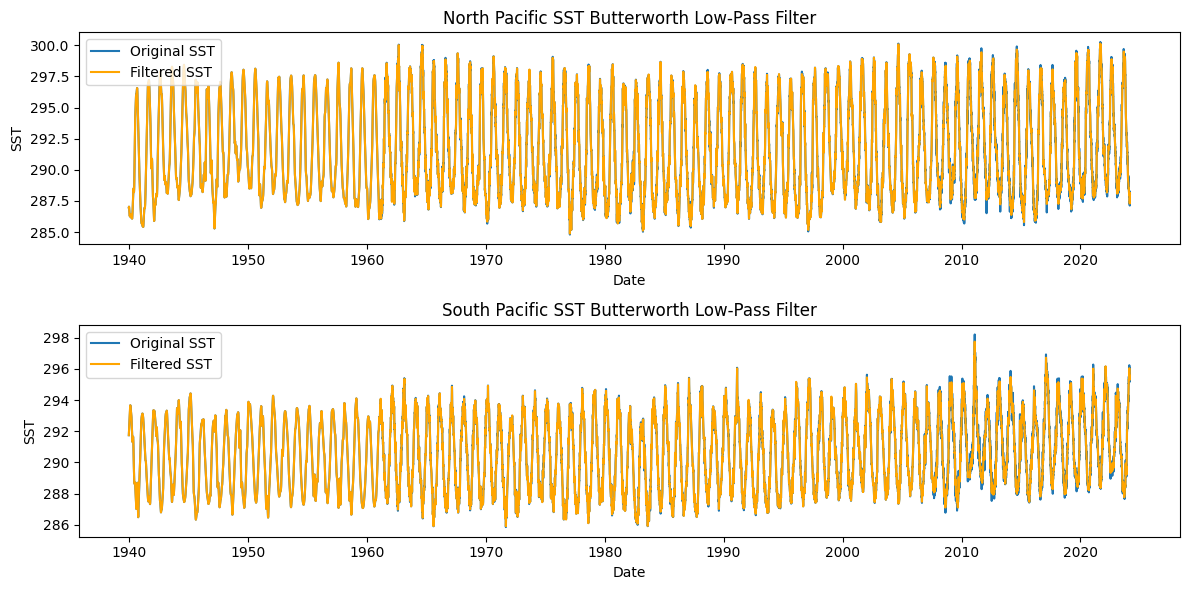

In [44]:
# Butterworth low-pass filter

north_pac_sst = north_pac['sst'].values
south_pac_sst = south_pac['sst'].values

# Design the Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filter parameters
cutoff_frequency = 0.1  # Adjust as needed
sampling_frequency = 1  # Assuming daily data
order = 5

# Apply the filter
north_pac_filtered = butter_lowpass_filter(north_pac_sst, cutoff_frequency, sampling_frequency, order)
south_pac_filtered = butter_lowpass_filter(south_pac_sst, cutoff_frequency, sampling_frequency, order)

# Plot the filtered data
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(north_pac['date'],
         north_pac_sst,
         label='Original SST')
plt.plot(north_pac['date'],
         north_pac_filtered,
         label='Filtered SST',
         color='orange')
plt.title('North Pacific SST Butterworth Low-Pass Filter')
plt.xlabel('Date')
plt.ylabel('SST')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(south_pac['date'],
         south_pac_sst,
         label='Original SST')
plt.plot(south_pac['date'],
         south_pac_filtered,
         label='Filtered SST',
         color='orange')
plt.title('South Pacific SST Butterworth Low-Pass Filter')
plt.xlabel('Date')
plt.ylabel('SST')
plt.legend()

plt.tight_layout()
plt.show()

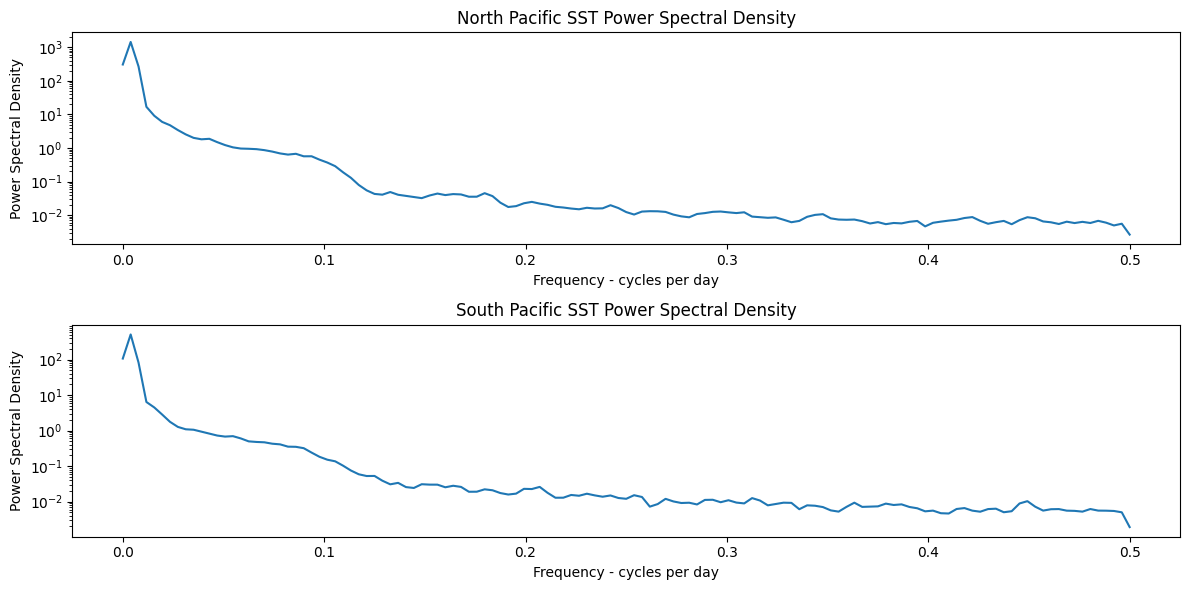

In [45]:
# Power Spectral Density

# Extract SST values
north_pac_sst = north_pac['sst'].values
south_pac_sst = south_pac['sst'].values

# Perform Power Spectral Density analysis using Welch's method
fs = 1  # Sample frequency

north_pac_freqs, north_pac_psd = welch(north_pac_sst, fs, nperseg=256)
south_pac_freqs, south_pac_psd = welch(south_pac_sst, fs, nperseg=256)

# Plot the PSD results for North Pacific
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.semilogy(north_pac_freqs, north_pac_psd)
plt.title('North Pacific SST Power Spectral Density')
plt.xlabel('Frequency - cycles per day')
plt.ylabel('Power Spectral Density')

# Plot the PSD results for South Pacific
plt.subplot(2, 1, 2)
plt.semilogy(south_pac_freqs, south_pac_psd)
plt.title('South Pacific SST Power Spectral Density')
plt.xlabel('Frequency - cycles per day')
plt.ylabel('Power Spectral Density')

plt.tight_layout()
plt.show()

# Time Series forecasting

Using time series forecasting to identify and isolate the season of winter component of the variable 'SST' or 'sea surface temperature' and forecast it a 1-2 years into the future.

We'll use the standard lag regression technique model for forecasting the 'SST'. First, we'll visualize the data to understand its structure.


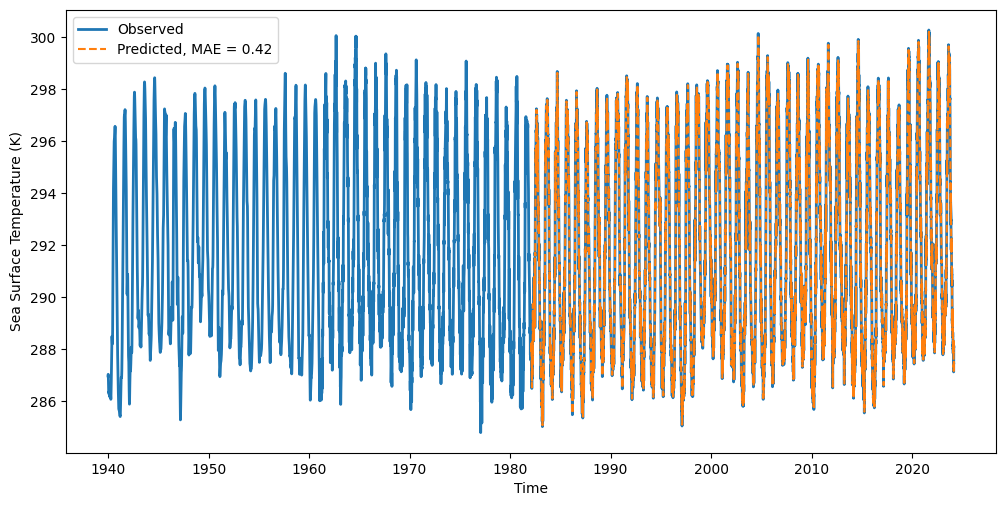

In [46]:
# North Pacific Ocean

# Define the lag
k = 4

# Prepare the data
sst_north = north_pac['sst'].values.reshape(-1, 1)

# Train-test split
train_indices = list(range(len(sst_north) // 2))
test_indices = list(range(len(sst_north) // 2, len(sst_north)))

sst_train = sst_north[train_indices]
sst_test = sst_north[test_indices]

# Create lagged variables
sst_lagged_train = sst_train[:-k]
sst_lagged_test = sst_test[:-k]
sst_train_target = sst_train[k:]
sst_test_target = sst_test[k:]

# Fit the model
reg = LinearRegression().fit(sst_lagged_train, sst_train_target)
sst_predicted = reg.predict(sst_lagged_test)

# Calculate MAE
mae = np.nanmean(np.abs(sst_predicted - sst_test_target))

# Plotting
time = np.array(north_pac['date'])
time_train = time[train_indices]
time_test = time[test_indices]

fig, ax = plt.subplots()
ax.plot(time, sst_north, '-', linewidth=2, label="Observed")
ax.plot(time_test[k:], sst_predicted, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Sea Surface Temperature (K)")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

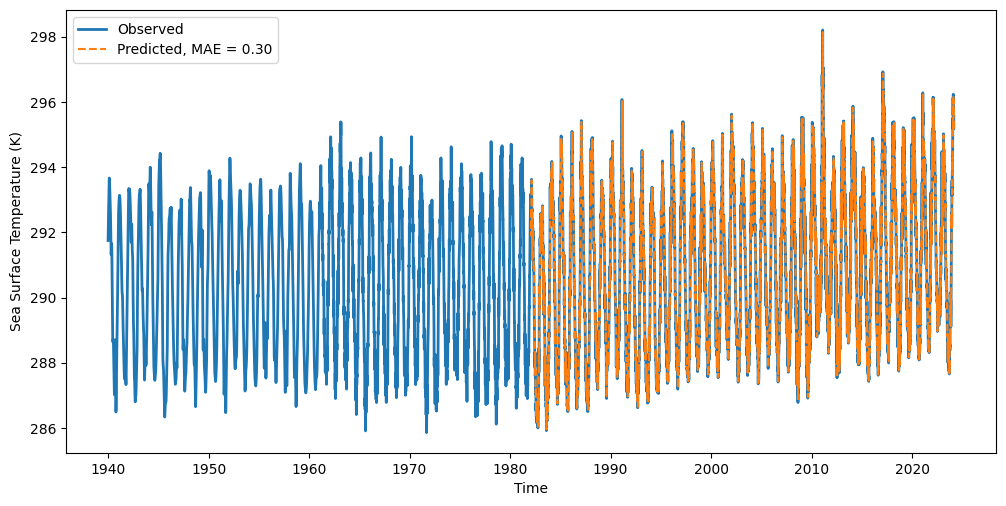

In [47]:
# South Pacific Ocean

# Prepare the data
sst_south = south_pac['sst'].values.reshape(-1, 1)

# Train-test split
train_indices = list(range(len(sst_south) // 2))
test_indices = list(range(len(sst_south) // 2, len(sst_south)))

sst_train = sst_south[train_indices]
sst_test = sst_south[test_indices]

# Create lagged variables
sst_lagged_train = sst_train[:-k]
sst_lagged_test = sst_test[:-k]
sst_train_target = sst_train[k:]
sst_test_target = sst_test[k:]

# Fit the model
reg = LinearRegression().fit(sst_lagged_train, sst_train_target)
sst_predicted = reg.predict(sst_lagged_test)

# Calculate MAE
mae = np.nanmean(np.abs(sst_predicted - sst_test_target))

# Plotting
time = np.array(south_pac['date'])
time_train = time[train_indices]
time_test = time[test_indices]

fig, ax = plt.subplots()
ax.plot(time, sst_south, '-', linewidth=2, label="Observed")
ax.plot(time_test[k:], sst_predicted, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Sea Surface Temperature (K)")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

# Additional Question using data science methodology

Based on the findings in the Spectral Analysis and Time series forecasting, I would like to figure out:

"What is the difference in the seasonal patterns of wave height between the North Pacific and South Pacific over the 80-year period?"

In [51]:
# Define seasons
def season_def(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

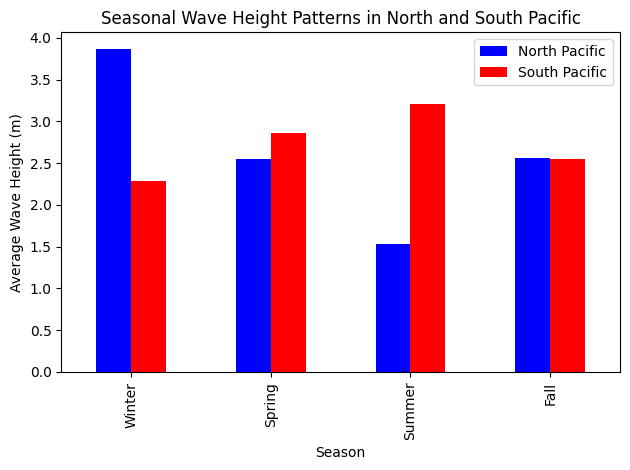

F_onewayResult(statistic=4013.2197710600126, pvalue=0.0)

In [55]:
# Apply the function to get season
north_pac['season'] = pd.to_datetime(north_pac['date']).apply(season_def)
south_pac['season'] = pd.to_datetime(south_pac['date']).apply(season_def)

# Aggregate wave height by season
north_seasonal_avg = north_pac.groupby('season')['hsig'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall'])
south_seasonal_avg = south_pac.groupby('season')['hsig'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

# Combine the data for plotting
seasonal_avg = pd.DataFrame({
    'North Pacific': north_seasonal_avg,
    'South Pacific': south_seasonal_avg
})

# Statistical Analysis: ANOVA
from scipy.stats import f_oneway

anova_results = f_oneway(
    north_pac[north_pac['season'] == 'Winter']['hsig'],
    north_pac[north_pac['season'] == 'Spring']['hsig'],
    north_pac[north_pac['season'] == 'Summer']['hsig'],
    north_pac[north_pac['season'] == 'Fall']['hsig'],
    south_pac[south_pac['season'] == 'Winter']['hsig'],
    south_pac[south_pac['season'] == 'Spring']['hsig'],
    south_pac[south_pac['season'] == 'Summer']['hsig'],
    south_pac[south_pac['season'] == 'Fall']['hsig']
)

# Plotting
fig, ax = plt.subplots()
seasonal_avg.plot(kind='bar', ax=ax, color=['blue', 'red'])
ax.set_xlabel('Season')
ax.set_ylabel('Average Wave Height (m)')
ax.set_title('Seasonal Wave Height Patterns in North and South Pacific')
plt.tight_layout()
plt.show()

anova_results


# Conclusion

Based on the 80 years of data collected by the ERA5 Reanalysis Product, this project is aimed at forecasting ocean basins to determine the effect of global warming. This project was completed using Spectral Analysis, Time series forecasting, and adding my own additional take on the project, I believe that the analysis above can further support climate change efforts.

